Nebuliser particle release: Valved Experiment at 2m
====================================================

### Authors: Ciarrai, James, Myriam, Marco

In [107]:
#pip install arrow
%pip install autograd

  Using cached autograd-1.5-py3-none-any.whl (48 kB)
  Using cached future-0.18.2.tar.gz (829 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491071 sha256=abfd6bd31436f3057dc8ce8661766b448e2fd4f7982b95b1b79fc6dccf720f60
  Stored in directory: /Users/marcofking/Library/Caches/pip/wheels/2f/a0/d3/4030d9f80e6b3be787f19fc911b8e7aa462986a40ab1e4bb94
Successfully built future
You should consider upgrading via the '/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


<div class="alert alert-warning">
Note: Before you use pyABC to parametrize your ODE, please be aware of potential errors introduced by inadequately representing the data generation process, see also the "Measurement noise assessment" notebook. For deterministic models, there are often more efficient alternatives to ABC, check out for example our tool <a href="https://github.com/ICB-DCM/pyPESTO">pyPESTO</a>.
</div>

We try to piece-wise fit the following concentration ODE, which assumes homogeneous mixing.


$$
   \dfrac{dC}{dt} = \dfrac{E}{V}-\lambda C
$$

Which has a general solution:

$$
C(t)=\dfrac{E}{V\lambda}(1-e^{-\lambda t})+ k e^{-\lambda t}
$$

Where $k$ is the integration constant.

We need to estimate $E$, $k$ and $\lambda$

In [1]:
# install if not done yet
#!pip install pyabc --quiet

In [106]:
%matplotlib inline

import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd

from pyabc import ABCSMC, RV, Distribution, LocalTransition, MedianEpsilon, SilkOptimalEpsilon
from pyabc.visualization import plot_data_callback, plot_kde_2d
from autograd import hessian

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "valved_02.db")

ModuleNotFoundError: No module named 'autograd'

Data
----

We use a data set which consists of a vector of time points $t$
and a measurement vector $Y$.  


and the measurement data

In [61]:
import pandas as pd
from datetime import datetime
import numpy as np
data = pd.read_csv('../data/vmn_ad_conc.txt', sep='\t',header=0) #valved data
data["time"] = data["time"].apply(lambda x: datetime.strptime(x, "%M:%S"))
data["fraction_of_hour"] = data["time"].apply(lambda x: (x.minute+x.second/60) / 60)
measurement_data = data['conc_08'] #np.array(data.loc[list(range(0,44)) + list(range(55, 135)), ['conc_2']])

as well as the time points at whith to evaluate

In [3]:
measurement_times = data['fraction_of_hour']#np.array(data.loc[list(range(0,44)) + list(range(55, 135)), ['fraction_of_hour']])

Define the analytical model:

 - for 0<$t$<5 minutes: $C=0.003851195$
 - for 5<$t$<15 minutes: $C = \dfrac{E}{V\lambda }(1-e^{-\lambda t})$
 - for 15<$t$<45 minutes: $C = k e^{-\lambda t}$

In [73]:
def model(param):
    """
    Model function for the piecewise solution.
    
    Parameters
    ----------
    param : tuple
        Tuple containing the values of the parameters k and lambda.
    t : array-like
        Array of time values.
        
    Returns
    -------
    C : array-like
        Array of concentration values at the given times.
    """
    E = param['E']
    k = param['k']
    lambda_ = param['lambda_']

    #E, k, lambda_ = param
    t = measurement_times
    # Initialize empty array for concentration values
    C = np.zeros_like(t)
    V = 44.34
    # Loop over time values
    for i, ti in enumerate(t):
        # If time is less than 5 minutes, set concentration to k
        if ti < 6/60:
            C[i] = 0.003679125
        # If time is between 5 and 20 minutes, set concentration according to ODE solution
        elif 5/60 <= ti < 15/60:
            C[i] =  (E/V)*(1-np.exp(-lambda_*(ti-5/60)))/lambda_ + k*np.exp(-lambda_*(ti-5/60)) 
        # If time is greater than 20 minutes, set concentration to 0
        else:
            C[i] = k*np.exp(-lambda_*(ti-15/60)) 
    # Add noise to the simulated data
    sigma = 0.001
    C += np.random.normal(0, sigma, size=C.shape)

    return {"Concentration":C}

#model({"E":0.0001,"k":0.003851195,"lambda_":0.0001})['Concentration'].shape

#distance({"Concentration":measurement_data}, model({"E":10,"k":0.003851195,"lambda_":1.11}))


Define the true parameters (chosen by eye using a manual piece-wise curve fitting of the VMN_ad_08 file.)

In [25]:
E_true, k_true, lambda_true = np.array([1.899, 0.101, 2.981])
#t1 = measurement_times[15:44]
#t1-np.min(t1)
#model({"E": E_true, "k": k_true, "lambda_":lambda_true})

Solve the model for the true parameter values and visualise the results

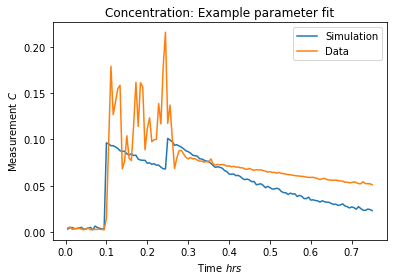

In [74]:
param = {"E": E_true, "k": k_true, "lambda_":lambda_true}
true_trajectory = model(param)["Concentration"]
import matplotlib.pyplot as plt
plt.plot(measurement_times,true_trajectory, color="C0", label='Simulation')
plt.plot(measurement_times, measurement_data, color="C1", label='Data')
plt.xlabel('Time $hrs$')
plt.ylabel('Measurement $C$')
plt.title('Concentration: Example parameter fit')
plt.legend()
plt.show()

#np.array(model({'E':3.851195,'k':0.003,'lambda_':1.174})).max()

In [12]:
def distance(simulation, data):
    return np.absolute(data["Concentration"] - simulation["Concentration"]).sum()

Define the prior for $E$, $k$ and $\lambda$

In [100]:
parameter_prior = Distribution(
    E=RV("uniform", 0, 30), k=RV("uniform", 0, 1), lambda_=RV("uniform", 0, 3)
)
parameter_prior.get_parameter_names()

['E', 'k', 'lambda_']

In [102]:
abc = ABCSMC(
    models=model,
    parameter_priors=parameter_prior,
    distance_function=distance,
    population_size=100,
    eps=SilkOptimalEpsilon(k=10),
    #transitions=LocalTransition(k_fraction=0.3),
    #eps=MedianEpsilon(1000, median_multiplier=0.7),
)

ImportError: Install autograd, e.g. via `pip install pyabc[autograd]`

In [91]:
abc.new(db_path, {"Concentration": measurement_data});

ABC.History INFO: Start <ABCSMC id=11, start_time=2022-12-24 21:55:44>


In [92]:
h = abc.run( max_nr_populations=10) #minimum_epsilon=1.5,

ABC INFO: t: 0, eps: 1.00000000e+03.
ABC INFO: Accepted: 100 / 103 = 9.7087e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 2.66775078e+01.
ABC INFO: Accepted: 100 / 279 = 3.5842e-01, ESS: 7.9826e+01.
ABC INFO: t: 2, eps: 5.60184557e+00.
ABC INFO: Accepted: 100 / 375 = 2.6667e-01, ESS: 7.9631e+01.
ABC INFO: t: 3, eps: 1.97189395e+00.
ABC INFO: Accepted: 100 / 696 = 1.4368e-01, ESS: 8.8279e+01.
ABC INFO: t: 4, eps: 1.20400376e+00.
ABC INFO: Accepted: 100 / 18480 = 5.4113e-03, ESS: 9.2665e+01.
ABC INFO: Stop: Minimum epsilon.
ABC.History INFO: Done <ABCSMC id=11, duration=0:00:15.351024, end_time=2022-12-24 21:56:00>


Visualization of the probability density functions for $E$, $k$ and $\lambda$

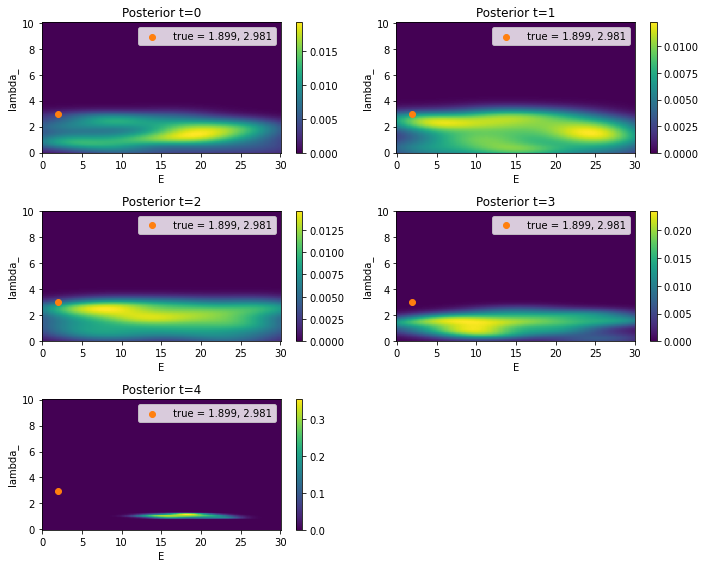

In [93]:
fig = plt.figure(figsize=(10, 8))
for t in range(h.max_t + 1):
    ax = fig.add_subplot(3, int(np.ceil(h.max_t / 3)), t + 1)

    ax = plot_kde_2d(
        *h.get_distribution(m=0, t=t),
        "E",
        "lambda_",
        xmin=0,
        xmax=30,
        numx=200,
        ymin=0,
        ymax=10,
        numy=200,
        ax=ax,
    )
    ax.scatter(
        [E_true],
        [lambda_true],
        color="C1",
        label=r' true = {:.3f}, {:.3f}'.format(
            E_true, lambda_true
        ),
    )
    ax.set_title(f"Posterior t={t}")

    ax.legend()
fig.tight_layout()

Plot marginal histograms of the posterior distributions of the three parameters

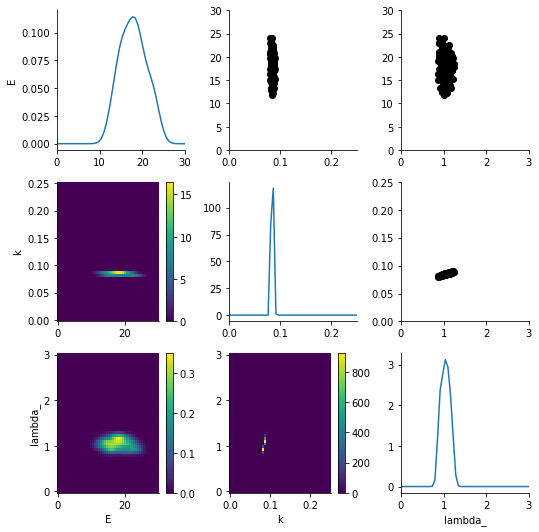

In [96]:
from pyabc.visualization import plot_kde_matrix

limits = dict(E=(0, 30), k=(0, .25), lambda_=(0, 3))
df, w = h.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits);

We can also plot the simulated trajectories:

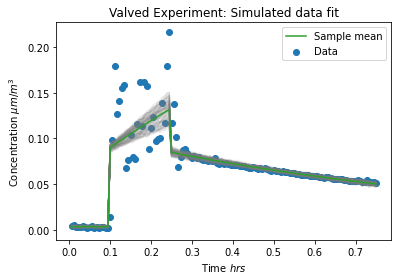

In [97]:
_, ax = plt.subplots()


def plot_data(sum_stat, weight, ax, **kwargs):
    """Plot a single trajectory"""
    ax.plot(measurement_times, sum_stat['Concentration'], color='grey', alpha=0.1)


def plot_mean(sum_stats, weights, ax, **kwargs):
    """Plot mean over all samples"""
    weights = np.array(weights)
    weights /= weights.sum()
    data = np.array([sum_stat['Concentration'] for sum_stat in sum_stats])
    mean = (data * weights.reshape((-1, 1))).sum(axis=0)
    ax.plot(measurement_times, mean, color='C2', label='Sample mean')


ax = plot_data_callback(h, plot_data, plot_mean, ax=ax)

#plt.plot(measurement_times,true_trajectory, color="C0", label='Initial guess')
plt.scatter(measurement_times, measurement_data, color="C0", label='Data')
plt.xlabel('Time $hrs$')
plt.ylabel('Concentration $\mu m/m^3$')
plt.title('Valved Experiment: Simulated data fit')
plt.legend()
plt.show()



Summary table of parameters

In [98]:
# Create a summary table of parameter values
df, w = h.get_distribution(m=0, t=h.max_t)
df['w'] = w
df = df.sort_values('w', ascending=True)
df = df.reset_index(drop=True)
df = df.round(3)
df.head(10)


name,E,k,lambda_,w
0,11.765,0.084,1.007,0.004
1,12.274,0.087,1.074,0.005
2,12.504,0.084,0.968,0.005
3,12.401,0.085,1.060,0.005
4,12.574,0.084,0.959,0.005
5,12.484,0.085,1.053,0.005
6,12.896,0.084,1.009,0.005
7,12.974,0.083,0.978,0.005
8,12.988,0.084,0.982,0.005
9,13.019,0.086,1.053,0.005
